# Late robustness

During the model training, we activate the robustness term only after the model expresses the basic topology of the data
In the robustness phase the decision boundaries are then diffused and robustified

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)
print("done")

56
done



# Data preparation

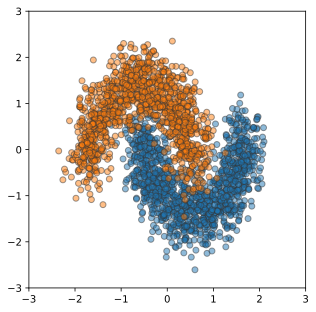

done


In [2]:
data_noise = 0.2
plotlim = [-3, 3]
subfolder = 'traj_moons'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('moons', noise = data_noise, plotlim = plotlim, random_state = seed, label = 'vector')
print("done")

## Model dynamics

In [3]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 20, 20
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = False
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside

## Training and generating level sets

In [10]:

num_epochs = 80 #number of optimization runs in which the dataset is used for gradient decent
eps = 0.2

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 

In [11]:
from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps_comp = 0.2) 
trainer_anode.train(dataloader, num_epochs)


Iteration 0/38
Loss: 1.565

Iteration 10/38
Loss: 1.499

Iteration 20/38
Loss: 1.845

Iteration 30/38
Loss: 1.600
Epoch 1: 1.526

Iteration 0/38
Loss: 1.470

Iteration 10/38
Loss: 1.396

Iteration 20/38
Loss: 1.484

Iteration 30/38
Loss: 1.516
Epoch 2: 1.389

Iteration 0/38
Loss: 1.446

Iteration 10/38
Loss: 1.508

Iteration 20/38
Loss: 1.407

Iteration 30/38
Loss: 1.413
Epoch 3: 1.322

Iteration 0/38
Loss: 1.411

Iteration 10/38
Loss: 1.123

Iteration 20/38
Loss: 1.183

Iteration 30/38
Loss: 1.134
Epoch 4: 1.257

Iteration 0/38
Loss: 1.268

Iteration 10/38
Loss: 1.210

Iteration 20/38
Loss: 1.266

Iteration 30/38
Loss: 1.106
Epoch 5: 1.174

Iteration 0/38
Loss: 1.145

Iteration 10/38
Loss: 1.150

Iteration 20/38
Loss: 1.104

Iteration 30/38
Loss: 1.031
Epoch 6: 1.106

Iteration 0/38
Loss: 1.257

Iteration 10/38
Loss: 1.006

Iteration 20/38
Loss: 1.253

Iteration 30/38
Loss: 0.901
Epoch 7: 1.043

Iteration 0/38
Loss: 1.031

Iteration 10/38
Loss: 0.883

Iteration 20/38
Loss: 0.946

Ite

### Check the basins of attraction

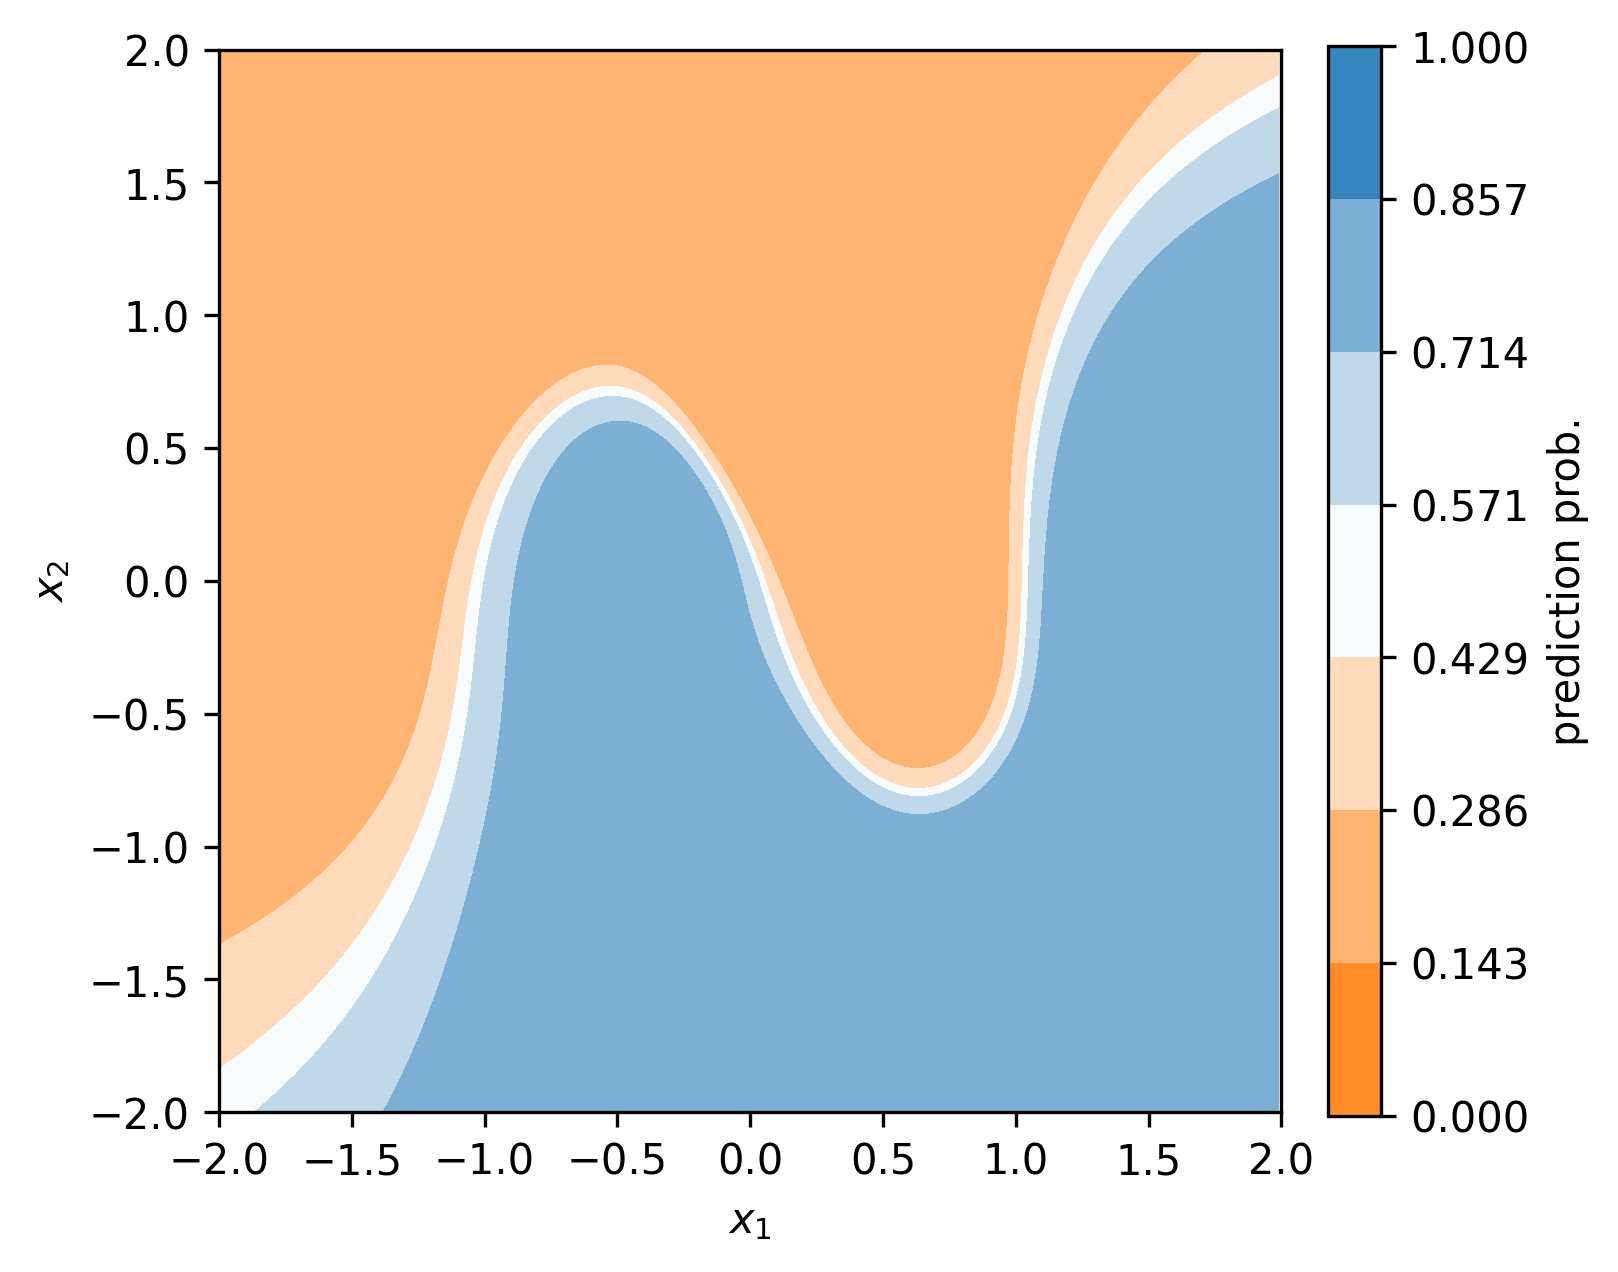

In [13]:
from plots.plots import classification_levelsets

classification_levelsets(anode, 'classification_levelsets')

from IPython.display import Image

img1 = Image(filename = 'classification_levelsets' + '.png', width = 400)
display(img1)

In [6]:
for X_viz, y_viz in dataloader_viz:
    X_viz = X_viz[0:5]
    break

trajectories = anode.flow.trajectory(X_viz, 10).detach()
print(X_viz)
print(trajectories.size()) #time is in the first coordinate

tensor([[-1.3000,  0.5603],
        [-0.3255, -1.1165],
        [-1.2043,  0.4415],
        [ 1.7537,  0.1016],
        [ 0.5258,  0.6008]])
torch.Size([10, 5, 2])


## Computation of the Maximal Lyapunov Exponent by integration 

In [67]:
'''
In this section, the set of function definitions needed to compute the Maximal Lyapunov Exponent by direct integration
(i.e. the nalaytical way) are coded.
'''

import numpy as np
import scipy

def linear_dynamics(node, derivative):
    '''
    Takes as input a nODE and return the augmented (flattened) linear system (f(x), Df(x)Y) as a 
    function of (x,Y) and t (flattened)
    '''
    if isinstance(node, NeuralODE):
        f_x = node.flow.dynamics.forward
        isnode = True
    else:
        f_x = node
        isnode = False
    
    def composed_lin_ODE(x_and_Y,t):
        '''
        Build the extended right hand side of the augmented (flattened) linear system (f(x), Df(x)Y)
        '''
        size_x = int((-1 + np.sqrt(1 + 4 * x_and_Y.size))/2)
        x = x_and_Y[:size_x]
        Y = np.reshape(x_and_Y[size_x:], [size_x, size_x])
        if isnode:
            x_torch = torch.from_numpy(x).type(torch.float32)
            x_torch.requires_grad=True
        else:
            x_torch = x
        f_x_torch = f_x(t, x_torch)
        if isnode:
            f_x_torch = f_x_torch.detach().numpy()
        
        def f_x_t(x):
            return f_x(t, x)
        Df_x = derivative(t, x_torch)
        if isnode: 
            Df_x = Df_x.numpy()
        Dfx_Y = np.matmul(Df_x, Y).flatten()
        rhs = np.concatenate((f_x_torch, Dfx_Y))
        return rhs
    
    return composed_lin_ODE


def local_FTLE(node, x, integration_time, dt = 0.5, der = torch.autograd.functional.jacobian):
    '''
    Full Maximal Lyapunov exponent computation, based on the lynear_dynamics function
    '''
    def numpy_rhs_from_node(t,x):
        x_torch = torch.from_numpy(x).type(torch.float32)
        x_torch.requires_grad=True
        f_x_torch = node.flow.dynamics.forward(t, x_torch)
        f_x_torch = f_x_torch.detach().numpy()
    
    if isinstance(node, NeuralODE):
        func = numpy_rhs_from_node
        der = torch.autograd.functional.jacobian
    else:
        func = node
    
    # start with evolving x forward for "a bit"
    print(func, x)
    x_t = scipy.integrate.odeint(func, x, [0, integration_time])
    x = x_t[-1]
    
    # set up of initial values
    Jac = np.identity(x.size)
    x_and_Jac_t = np.concatenate((x,Jac.flatten()))
    L = np.zeros(x.size)

    # first flow forward
    x_and_Jac_t = scipy.integrate.odeint(linear_dynamics(node, der), x_and_Jac_t, [0, integration_time])
    Jac_t = select_Jac_int(x_and_Jac_t)
    Q_t, R_t = np.linalg.qr(Jac_t)
    x_and_Jac_t = np.concatenate((select_x_int(x_and_Jac_t),Q_t.flatten()))

    #selection functionalities
    select_Jac_int = lambda mat: np.reshape(mat[-1,x.size:],[x.size,x.size])
    select_x_int = lambda mat: mat[-1,:x.size]

    # set up of time values 
    start_time = 0
    length_iter = integration_time#dt * 15
    iters = 1 #np.floor(integration_time/length_iter).astype(int) # number of iterations done
    n_start_iter = 0# iters - 2# np.floor(iters/20) # 20% of the integration time used to get in position
    used_time = (iters - n_start_iter) * length_iter
    for i in range(iters):
        time_array_iter = start_time + np.arange(0, length_iter, dt)
        start_time = time_array_iter[-1]
        x_and_Jac_t = scipy.integrate.odeint(linear_dynamics(node, der), x_and_Jac_t, time_array_iter)
        
        Jac_t = select_Jac_int(x_and_Jac_t)
        Q_t, R_t = np.linalg.qr(Jac_t)
        x_and_Jac_t = np.concatenate((select_x_int(x_and_Jac_t),Q_t.flatten())) # for numerical stability

        # if the system has stabilised, the lyapunov computation takes place
        if i >= n_start_iter:
            if any(np.diagonal(R_t)<0):
                if any(np.diagonal(R_t)>0):
                    print('R_t has both negative and positive values on the diagonal')
                    print(np.diagonal(R_t), flush = True)
                    print('with eigenvalues:', np.linalg.eig(Jac_t).eigenvalues)
                    return np.nan
                R_t = - R_t
                Q_t = - Q_t
            L += np.log(np.diagonal(R_t)) # the QR decomposition seems to, at times, give negative Rs, why??
        
    #print(R_t, L)
    return (L/used_time)



In [26]:
## easier test case
def linear_function(x):
    # A = np.random.rand(x.size,x.size)
    A = np.array([[-1,-1],[1,0]])
    print('Eigenvalues = ', np.linalg.eig(A).eigenvalues)
    def func(t, x_func):
        return np.matmul(A,x_func)
    def derivative(t, x_func):
        return A
    return func, derivative

lin_func, der = linear_function(x)
print(15%5)

x = np.array([2,3])
integration_time = 100
dt = 0.02
lin_func(0, x)
for i in range(1,10):
    print(local_FTLE(lin_func, x, i*integration_time, dt, der))
# for linear functions, the computed FTLE seems correct up to numerical error, but the error is always noticeable, even if not big

Eigenvalues =  [-0.5+0.8660254j -0.5-0.8660254j]
0
[-0.46119378 -0.46919551]
[-0.46705659 -0.4648025 ]
[-0.46726617 -0.46508492]
[-0.46527809 -0.46731881]
[-0.46617941 -0.46656454]
[-0.46681123 -0.4660311 ]
[-0.46656556 -0.466347  ]
[-0.46610296 -0.46686212]
[-0.46654785 -0.46645822]


In [72]:
## a little harder test case
def lorenz():
    sigma = 10
    beta = 8/3
    rho = 28
    def func(x_func, t):
        #print(t)
        x = x_func[0]
        y = x_func[1]
        z = x_func[2]
        lor = np.array([sigma*(y-x), x*(rho - z)-y, x*y - beta*z])
        return lor
    def derivative(x_func, t):
        x = x_func[0]
        y = x_func[1]
        z = x_func[2]
        return np.array([[-sigma, sigma, 0],[rho-z, -1, -x],[y, x, -beta]])
    return func, derivative

In [74]:
lor_func, lor_der = lorenz()
print(lor_func([1,2,3], 0))
print(lor_der([1,2,3], 0))

[10. 23. -6.]
[[-10.          10.           0.        ]
 [ 25.          -1.          -1.        ]
 [  2.           1.          -2.66666667]]


In [112]:
def simple_lyap(f, dxf, x, t = 100):
    x_t = scipy.integrate.odeint(f, x, np.arange(0, t, 0.01))
    # ax = plt.figure().add_subplot(projection='3d')
    # ax.plot(x_t[-10000:,0], x_t[-10000:,1], x_t[-10000:,2])
    # plt.show()
    x = x_t[-1]
    x_and_Jac = np.concatenate((x, np.eye(x.size).flatten()))
    f_and_dxf = lambda x,t: np.concatenate((f(x,t), dxf(x,t).flatten()))
    x_and_Jac_t = scipy.integrate.odeint(f_and_dxf, x_and_Jac, np.arange(t, 2*t, 0.01))
    x_t = x_and_Jac_t[-10000:,:3]
    # ax = plt.figure().add_subplot(projection='3d')
    # ax.plot(x_t[:,0], x_t[:,1], x_t[:,2])
    # plt.show()
    Jac_final = np.reshape(x_and_Jac_t[-1,x.size:],[x.size, x.size])
    Lyap_mat = 1/(2*t) * np.matmul(Jac_final.transpose(), Jac_final)
    lyap_exp = np.log(np.linalg.eig(Lyap_mat).eigenvalues)
    return lyap_exp


def stable_lyap(f, dxf, x, t = 100):
    # set up x
    x_t = scipy.integrate.odeint(f, x, np.arange(0, t, 0.01))
    x = x_t[-1]
    # some defs
    x_and_Jac = np.concatenate((x, np.eye(x.size).flatten()))
    f_and_dxf = lambda x,t: np.concatenate((f(x,t), dxf(x,t).flatten()))
    lyap = np.zeros(x.size)
    for i in range(10):
        x_and_Jac_t = scipy.integrate.odeint(f_and_dxf, x_and_Jac, np.arange(t+i*t/10, t + (i+1)*t/10, 0.01))
        Jac_iter = np.reshape(x_and_Jac_t[-1,x.size:],[x.size, x.size])
        Q_t, R_t = np.linalg.qr(Jac_iter)
        x_and_Jac = np.concatenate((x_and_Jac_t[-1,:x.size], Q_t.flatten()))
        if i > 3:
            lyap = lyap + np.log(np.max(R_t.diagonal()))
    return lyap/(0.7*t)


# scipy.integrate.odeint(lor_func, np.array([1,2,3]), np.array([0, 1]))
print(simple_lyap(lor_func, lor_der, np.array([1,2,3]), 100))
print(stable_lyap(lor_func, lor_der, np.array([1,2,3]), 300))

[9.282958   5.35067059 6.0926861 ]
[0.16568776 0.16568776 0.16568776]


In [117]:
Q, R = np.linalg.qr([[1,2,3],[7,6,5],[10,11,12]])
print(Q,'\n', R,'\n', np.matmul(Q,R))

[[-0.08164966  0.57221912 -0.81602611]
 [-0.57154761 -0.697637   -0.43201382]
 [-0.81649658  0.43112399  0.38401229]] 
 [[-1.22474487e+01 -1.25740473e+01 -1.29006460e+01]
 [ 0.00000000e+00  1.70098011e+00  3.40196022e+00]
 [ 0.00000000e+00  0.00000000e+00  8.87744739e-15]] 
 [[ 1.  2.  3.]
 [ 7.  6.  5.]
 [10. 11. 12.]]


In [71]:
x = np.array([1,2,3])
integration_time = 100
dt = 0.02
print(local_FTLE(lor_func, x, integration_time, dt, lor_der))

<function lorenz.<locals>.func at 0x15248d1f0> [1 2 3]


TypeError: 'float' object is not subscriptable

In [36]:
import time

# sanity check:
l = local_FTLE(anode, np.array([0.1,-0.5]), 1, 0.1)

x_amount = 5
integration_time = T
dt = 0.1

x = np.linspace(-2,2,x_amount)
y = np.linspace(-2,2,x_amount)
X, Y = np.meshgrid(x, y)
XY = np.array([X.flatten(), Y.flatten()])

lyap = np.zeros(x_amount**2)
start_time = time.time()
for i in range(x_amount**2):
    # print(XY[:,i])
    lyap[i] = np.max(local_FTLE(anode, XY[:,i], integration_time, dt))
    iteration_time = time.time() - start_time
    if np.mod(i, 10) == 0:
        print(i+1,' out of ', x_amount**2, ' after ', iteration_time)
    #print(lyap[i])
    #break
lyap = np.reshape(lyap, (x_amount,x_amount))
# print(lyap)

1  out of  25  after  0.9586350917816162
11  out of  25  after  10.376305103302002
21  out of  25  after  20.001791954040527


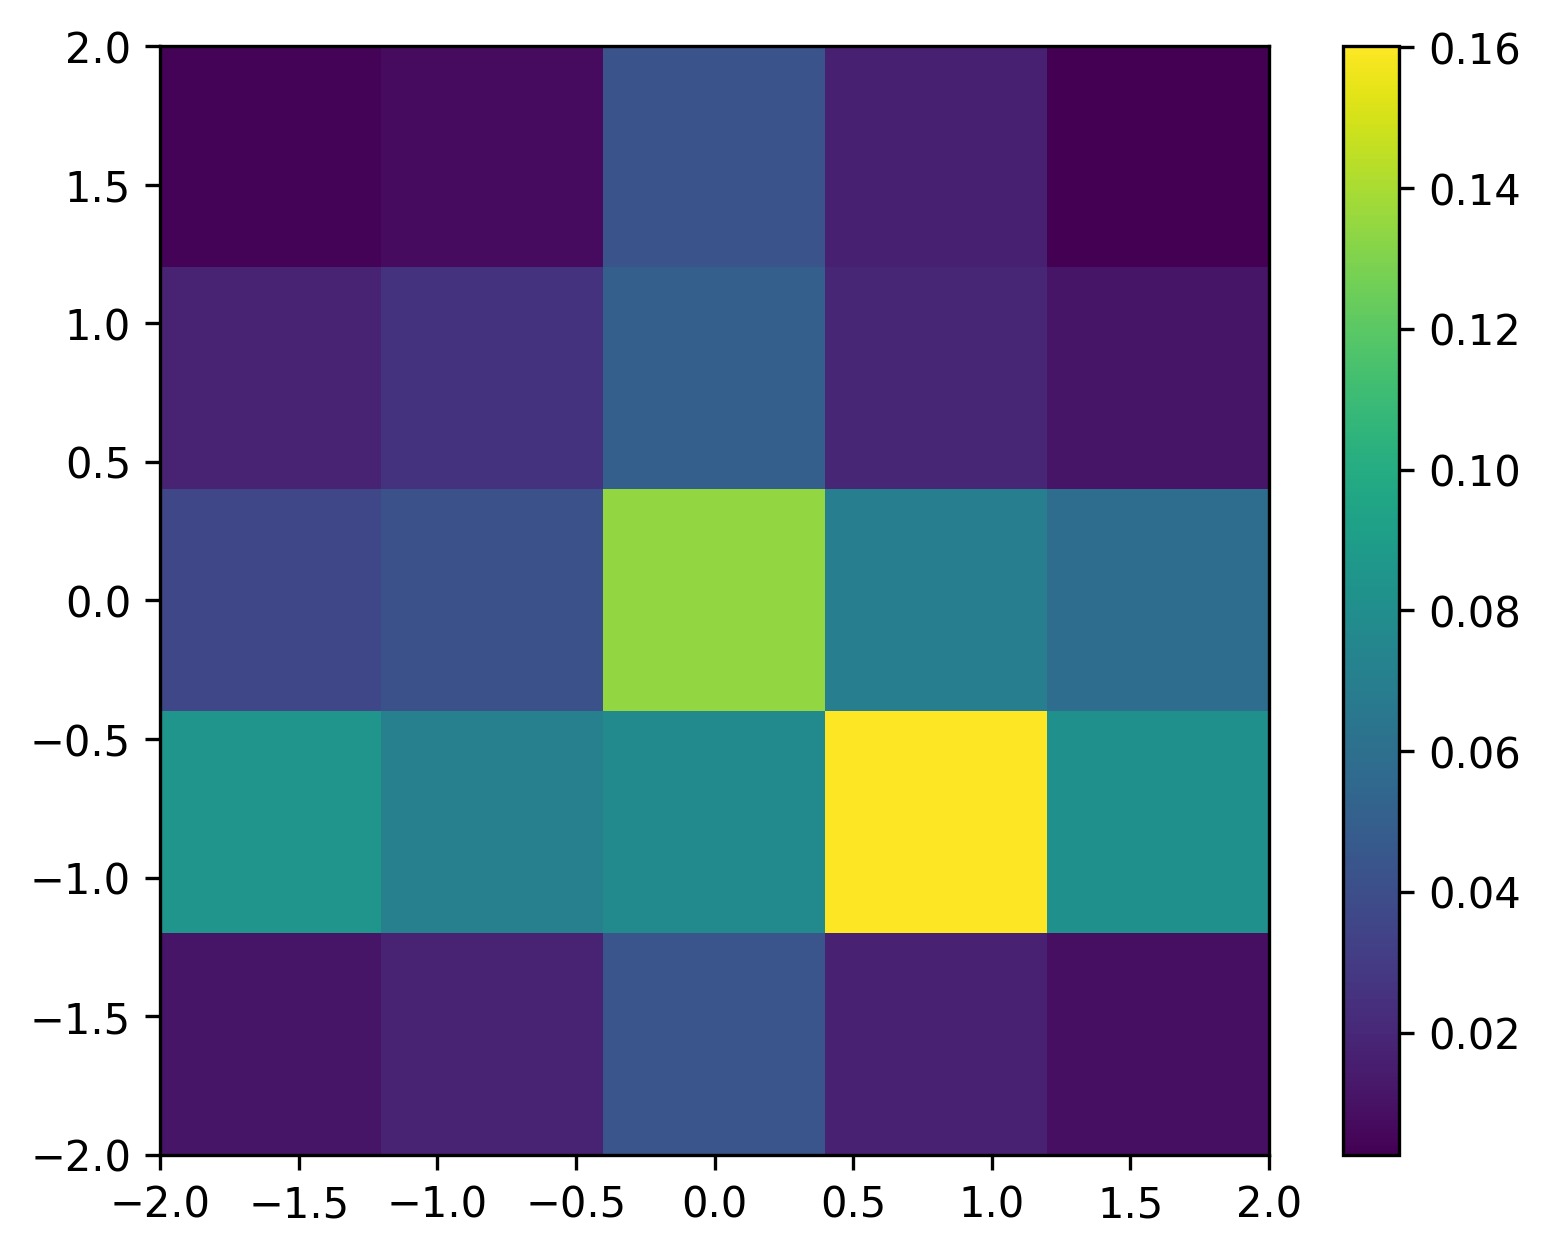

In [37]:
# Create heatmap using imshow
from IPython.display import Image

file_name = 'MLE_analytic_3.png'

anodeimg = plt.imshow(np.rot90(lyap), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
vmin, vmax = anodeimg.get_clim()
plt.colorbar()  # Show color scale
plt.savefig(file_name, bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

img1 = Image(file_name, width = 400)
display(img1)

In [126]:
# testing the auto grad function 
testing = False
if testing:
    w = torch.rand(2,2)
    b = torch.rand(2)
    print(w, b)
    def exp_reducer(x):
         return torch.matmul(w, x) + b

    inputs = torch.rand(2)

    print(torch.autograd.functional.jacobian(exp_reducer, inputs))

In [127]:
# TESTING 
testing = False
if testing:
    x = np.array([1., 2.]) # point where we compute the MLE
    Jac = np.identity(2)     # vector with appropriate size
    x_and_Jac = np.concatenate((x,Jac.flatten())).astype(np. double)
    dt = 0.1
    integration_time = 1.
    time_array = np.arange(0, integration_time, dt)
    debug_MLE = False
    f_x = anode.flow.dynamics.forward
    f_x(integration_time, torch.from_numpy(x).type(torch.float32)) # this now works
    CLO = linear_dynamics(anode)
    CLO(x_and_Jac, integration_time)

    out = scipy.integrate.odeint(linear_dynamics(anode), x_and_Jac, time_array)
    # out has one entry for each time

    # we are only interested in the last time integration, that we reshape as a matrix
    L = np.reshape(out[-1,2:],[2,2])

    print('\nL = ', L)
    print('\nlog( L * L.T )= ', np.log(np.matmul(L, L.transpose())))
    
    lyap_exp = np.linalg.eig( 1/(2*integration_time) * np.log(np.matmul(L, L.transpose())))
    
    print('\nLyap exps = ', lyap_exp.eigenvalues)
    
    # using the full function
    l = local_FTLE(anode, np.array([0.1,-0.5]), 1)
    print('Local FTLE = ', l)

In [ ]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz[0:50], y_viz[0:50], timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
    trajectory_gif(rnode, X_viz[0:50], y_viz[0:50], timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)
    break

#Display of the generated gif
traj = Image(filename="trajectory.gif")
rtraj = Image(filename="trajectory_db.gif")
display(traj, rtraj)

In [ ]:
from IPython.display import Image
from plots.plots import comparison_plot
# traj = Image(filename="trajectory19.png", retina = True)
# rtraj = Image(filename="trajectory_db19.png", retina = True)
# display(traj, rtraj)

comparison_plot("trajectory39.png", 'standard training', "trajectory_db39.png", 'robust training', 'traj_comp.png')
display(Image('traj_comp.png', width = 800))

I want to visualize the separation boundary in the final linear layer.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import torch
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
from matplotlib.colors import to_rgb
import imageio

from matplotlib.colors import LinearSegmentedColormap
import os


@torch.no_grad()
def linlayer_levelsets(model, fig_name=None, footnote=None, contour = True, plotlim = [-2, 2]):
    
    
    x1lower, x1upper = plotlim
    x2lower, x2upper = plotlim

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    fig = plt.figure(figsize=(5, 5), dpi=100)
    
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.figtext(0.5, 0, footnote, ha="center", fontsize=10)

    
   
    model.to(device)

    x1 = torch.arange(x1lower, x1upper, step=0.01, device=device)
    x2 = torch.arange(x2lower, x2upper, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    
    preds = model.linear_layer(model_inputs)
    
    # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
    m = nn.Softmax(dim=2)
    # softmax normalizes the model predictions to probabilities
    preds = m(preds)

    #we only need the probability for being in class1 (as prob for class2 is then 1- class1)
    preds = preds[:, :, 0]
    preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
    
    plt.grid(False)
    plt.xlim([x1lower, x1upper])
    plt.ylim([x2lower, x2upper])

    ax = plt.gca()
    ax.set_aspect('equal') 
    
    if contour:
        colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is orange, last is blue
        cm = LinearSegmentedColormap.from_list(
            "Custom", colors, N=40)
        z = np.array(preds).reshape(xx1.shape)
        
        levels = np.linspace(0.,1.,20).tolist()
        
        cont = plt.contourf(xx1, xx2, z, levels, alpha=1, cmap=cm, zorder = 0, extent=(x1lower, x1upper, x2lower, x2upper)) #plt.get_cmap('coolwarm')
        cbar = fig.colorbar(cont, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel('prediction prob.')
    

    if fig_name:
        plt.savefig(fig_name + '.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
        plt.clf()
        plt.close()
    # else: plt.show()

In [ ]:
linlayer_levelsets(anode)

In [ ]:
@torch.no_grad()
def trajectory_gif_new(model, inputs, targets, timesteps, dpi=200, alpha=0.9,
                   alpha_line=1, filename='trajectory.gif', axlim = 0):
    
    from matplotlib import rc
    from scipy.interpolate import interp1d
    rc("text", usetex = False)
    font = {'size'   : 18}
    rc('font', **font)

    if not filename.endswith(".gif"):
        raise RuntimeError("Name must end in with .gif, but ends with {}".format(filename))
    base_filename = filename[:-4]

    ## We focus on 3 colors at most
    if False in (t < 2 for t in targets): 
        color = ['mediumpurple' if targets[i] == 2.0 else 'gold' if targets[i] == 0.0 else 'mediumseagreen' for i in range(len(targets))]
    else:
        #color = ['crimson' if targets[i, 0] > 0.0 else 'dodgerblue' for i in range(len(targets))]
        color = ['C1' if targets[i] > 0.0 else 'dimgrey' for i in range(len(targets))]

    trajectories = model.flow.trajectory(inputs, timesteps).detach()
    num_dims = trajectories.shape[2]

    if axlim == 0:        
        x_min, x_max = trajectories[:, :, 0].min(), trajectories[:, :, 0].max()
        y_min, y_max = trajectories[:, :, 1].min(), trajectories[:, :, 1].max()
    else: 
        x_min, x_max = -axlim, axlim  #to normalize for rob and standard nODE
        y_min, y_max = -axlim, axlim   #
        
    if num_dims == 3:
        z_min, z_max = trajectories[:, :, 2].min(), trajectories[:, :, 2].max()
    margin = 0.1
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= margin * x_range
    x_max += margin * x_range
    y_min -= margin * y_range
    y_max += margin * y_range
    if num_dims == 3:
        z_range = z_max - z_min
        z_min -= margin * z_range
        z_max += margin * z_range
        
    T = model.T 
    integration_time = torch.linspace(0.0, T, timesteps)
    
    interp_x = []
    interp_y = []
    interp_z = []
    for i in range(inputs.shape[0]):
        interp_x.append(interp1d(integration_time, trajectories[:, i, 0], kind='cubic', fill_value='extrapolate'))
        interp_y.append(interp1d(integration_time, trajectories[:, i, 1], kind='cubic', fill_value='extrapolate'))
        if num_dims == 3:
            interp_z.append(interp1d(integration_time, trajectories[:, i, 2], kind='cubic', fill_value='extrapolate'))
    
    interp_time = 20
    # interp_time = 3 #this was 5 before
    _time = torch.linspace(0., T, interp_time)

    plt.rc('grid', linestyle="dotted", color='lightgray')
    for t in range(interp_time):
        if num_dims == 2:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            label_size = 13
            plt.rcParams['xtick.labelsize'] = label_size
            plt.rcParams['ytick.labelsize'] = label_size 
            ax.set_axisbelow(True)
            ax.xaxis.grid(color='lightgray', linestyle='dotted')
            ax.yaxis.grid(color='lightgray', linestyle='dotted')
            ax.set_facecolor('whitesmoke')
            
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            plt.rc('text', usetex=False)
            plt.rc('font', family='serif')
            plt.xlabel(r'$x_1$', fontsize=12)
            plt.ylabel(r'$x_2$', fontsize=12)
            
            x1 = torch.arange(x_min, x_max, step=0.01, device=device)
            x2 = torch.arange(y_min, y_max, step=0.01, device=device)
            xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
            model_inputs = torch.stack([xx1, xx2], dim=-1)
            
            preds = model.linear_layer(model_inputs)
            
            # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
            m = nn.Softmax(dim=2)
            # softmax normalizes the model predictions to probabilities
            preds = m(preds)

            #we only need the probability for being in class1 (as prob for class2 is then 1- class1)
            preds = preds[:, :, 0]
            preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
            
            plt.grid(False)
    

            ax = plt.gca()
            ax.set_aspect('equal') 
            
            
            colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is orange, last is blue
            cm = LinearSegmentedColormap.from_list(
                "Custom", colors, N=40)
            z = np.array(preds).reshape(xx1.shape)
            
            levels = np.linspace(0.,1.,15).tolist()
            
            cont = plt.contourf(xx1, xx2, z, levels, alpha=0.5, cmap=cm, zorder = 0, extent=(x_min, x_max, y_min, y_max)) #plt.get_cmap('coolwarm')
            
            
            
            
            plt.scatter([x(_time)[t] for x in interp_x], 
                         [y(_time)[t] for y in interp_y], 
                         c=color, alpha=alpha, marker = 'o', linewidth=0.65, edgecolors='black', zorder=3)

            if t > 0:
                for i in range(inputs.shape[0]):
                    x_traj = interp_x[i](_time)[:t+1]
                    y_traj = interp_y[i](_time)[:t+1]
                    plt.plot(x_traj, y_traj, c=color[i], alpha=alpha_line, linewidth = 0.75, zorder=1)
            
        
        ax.set_aspect('equal')

        plt.savefig(base_filename + "{}.png".format(t),
                    format='png', dpi=dpi, bbox_inches='tight', facecolor = 'white')
        # Save only 3 frames (.pdf for paper)
        # if t in [0, interp_time//5, interp_time//2, interp_time-1]:
        #     plt.savefig(base_filename + "{}.pdf".format(t), format='pdf', bbox_inches='tight')
        plt.clf()
        plt.close()

    imgs = []
    for i in range(interp_time):
        img_file = base_filename + "{}.png".format(i)
        imgs.append(imageio.imread(img_file))
        if i not in [0, interp_time//5, interp_time//2, interp_time-1]: os.remove(img_file) 
    imageio.mimwrite(filename, imgs, duration = 500)

In [ ]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

data_iter = iter(dataloader)
X,y = next(data_iter)
batch_size = 40

X_viz = torch.zeros_like(X[0:batch_size])
y_viz = torch.zeros(batch_size)
print(y_viz.size())
print(X_viz.size())
X_viz[:,1] = torch.linspace(-5,5,batch_size)
X_viz[:,0] = torch.tensor([0])
print(X_viz)

# plt.scatter(X_viz[:,0],X_viz[:,1])

trajectory_gif_new(anode, X_viz[0:batch_size], y_viz[0:batch_size], timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
trajectory_gif_new(rnode, X_viz[0:batch_size], y_viz[0:batch_size], timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)